# Map Gifs

> In this tutorial, the basics of creating map gifs is introduced

This Coding Notebook is the __fourth__ in a series.

Interactive examples are provided along the way.

This colab and more can be found at https://github.com/BNIA/colabs

- Content covered in previous tutorials will be used in later tutorials. 

- __new code and or  information *should* have explanations and or descriptions__ attached. 

- Concepts or code covered in previous tutorials will be used without being explaining in entirety.

- __If content can not be found in the current tutorial and is not covered in previous tutorials, please let me know.__

## Introduction

**Description:** This notebook was made to demonstrate how to make a gif map by merging 2 datasets. The first being a dataset containing mappable coordinates onto which the second dataset may mapping its information of interest. 

This lab is split into two sections. 
- The first part of this lab provides help you understand the basics operations.
- The second part of this notebook provides a single python function that handles everything covered in this lab (and more). 

**Input(s):** 
- Dataset (points/ bounds) url
- Points/ bounds geometry column(s)
- Points/ bounds crs's
- Points/ bounds mapping color(s)
- New filename

**Output:** Files, Gif

__*please note__

- This lab in particular makes heavy use of data that is not publicly accessible. Later labs use functions created here on public data. 
- A table of contents is provided in the menu to the left.
- And, that this notebook has been optimized for Google Colabs ran on a Chrome Browser. 
- While still fully usable, non-critical section of code (eg. Python Magics and HTML) may break if used in a different enviornment.

# Guided Walkthrough

## Background

#### Coordinate Reference Systems (CRS)

Read Make sure the appropriate spatial Coordinate Reference System (CRS) is used when reading in your data!

CRS 4326 is th CRS most people are familar with when refering to latiude and longitudes.

Baltimore's 4326 CRS should be at (39.2, -76.6)

BNIA uses CRS 2248 internally #http://www.spatialreference.org/ref/epsg/2248/

Make sure all your dataset coordinates are using the same CRS

Perform conversions where needed 

Additional Information: https://docs.qgis.org/testing/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

Census Geographic Data:
- **Geographic Coordinate Data** is provided by the census and compliments their census geographies 
- https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html
- https://www.census.gov/programs-surveys/acs/geography-acs/geography-boundaries-by-year.html 
- Bnia created and provides for free geographic boundary data that compliment these CSA's

## SETUP

### Import Modules

In [ ]:
%%capture #supress_output

# Install the Widgets Module. 
# Colabs does not locally provide this Python Library
# The '!' is a special prefix used in colabs when talking to the terminal
!pip install geopandas

In [ ]:
#@title Run This Cell: Import Modules

# Once installed we need to import and configure the Widgets
import ipywidgets as widgets
!jupyter nbextension enable --py widgetsnbextension
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Used 4 Importing Data
import urllib.request as urllib 
from urllib.parse import urlencode 
# This Prevents Timeouts when Importing
import socket 
socket.setdefaulttimeout(10.0)

# Pandas Data Manipulation Libraries
import pandas as pd
# Show entire column widths
pd.set_option('display.max_colwidth', -1)
# 4 Working with Json Data
import json 
# 4 Data Processing
import numpy as np
# 4 Reading Json Data into Pandas
from pandas.io.json import json_normalize

# 4 exporting data as CSV
import csv


# Geo-Formatting
# Postgres-Conversion
import geopandas as gpd
import psycopg2,pandas,numpy
from shapely import wkb
import os
import sys

# In case file is KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts

from geopandas import GeoDataFrame

from shapely.wkt import loads
from pandas import ExcelWriter
from pandas import ExcelFile

# load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import glob

# Gif
import imageio

# Pictures
from PIL import Image
import requests
from io import BytesIO

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Configure Enviornment

In [ ]:
# This will just beautify the output

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('display.precision', 2)
# pd.reset_option('max_colwidth')
pd.set_option('max_colwidth', 20)
# pd.reset_option('max_colwidth')

### (Optional) Local File Access

In [ ]:
# (Optional) Run this cell to gain access to Google Drive (Colabs only) 
from google.colab import drive

# Colabs operates in a virtualized enviornment
# Colabs default directory is at ~/content.
# We mount Drive into a temporary folder at '~/content/drive' 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### File Access Conveince Functions 

In [ ]:
# Find Relative Path to Files
def findFile(root, file):
    for d, subD, f in os.walk(root):
        if file in f:
            return "{1}/{0}".format(file, d)
            break 

# To 'import' a script you wrote, map its filepath into the sys
def addPath(root, file): sys.path.append(os.path.abspath( findFile( './', file) ))

### Conveince Functions 

In [ ]:
def getColName  (df, col): return df.columns[df.columns.str.contains(pat = col)][0] 
def getColByName (df, col): return df[getColName(df, col)]
def addKey(df, fi, col):
    key = getColName(df, col)
    val = getColByName(df, col)
    fi[key] = val
    return fi
def nullIfEqual(df, c1, c2): 
    return df.apply(lambda x: 
        x[getColName(df, c1)]+x[getColName(df, c2)] if x[getColName(df, c1)]+x[getColName(df, c2)] != 0 else 0, axis=1)
def sumInts(df): return df.sum(numeric_only=True)

This next function was created in previous colabs. We are going to recycle it for use in this lab

In [ ]:
#@title Run This Cell: Create mergeDatasets()

def mergeDatasets(df=False, cw=False, left_on=False, right_on=False, how=False, save=False, name=False ): 
    
    
  # Check if the columns actually exist
  def checkColumns(df, cw, left_on, right_on, how): 
    dfkeyexist = {left_on}.issubset(df.columns)
    cwkeyexist = {right_on}.issubset(cw.columns) 
    cscolexist = ( {how}.issubset(cw.columns) or 
                  how in ['left', 'right', 'outer', 'inner'] )

    print('df', dfkeyexist, 'cw', cwkeyexist, 'cs', cscolexist)
    
    return (dfkeyexist and cwkeyexist and cscolexist)

  # Ensure data types are the same
  def coerceDtypes(df, cw, left_on, right_on):
    status = False
    foreignDtype = cw[right_on].dtype
    localDtype = df[left_on].dtype  
    
    # Coerce one way or the other if possible
    if localDtype == 'int64' and foreignDtype == 'object':
      print('Converting Foreign Key from Object to Int' )
      cw[right_on] = pd.to_numeric(cw[right_on], errors='coerce')
      foreignDtype = cw[right_on].dtype
      
    if localDtype == 'object' and foreignDtype == 'int64':
      print('Converting Foreign Key from Object to Int' )
      df[left_on] = pd.to_numeric(df[left_on], errors='coerce')
      localDtype = df[left_on].dtype
      
    # Return the data and the coerce status
    if localDtype == foreignDtype: status = True
    return df, cw, status


  # Decide to perform a merge or commit a pull
  def mergeOrPull(df, cw, left_on, right_on, how):  
    
    def merge(df, cw, left_on, right_on, how):
      print('Merging', left_on, right_on, how); 
      df = pd.merge(df, cw, left_on=left_on, right_on=right_on, how=how)
      # df.drop(left_on, axis=1)
      df[right_on] = df[right_on].fillna(value='empty')
      return df

    def pull(df, cw, left_on, right_on, how):
      crswlk = dict(zip(cw[right_on], cw[how]  ) )
      dtype = df[left_on].dtype
      # print('Pulling'); 
      # print('df.columns', left_on, df[left_on].dtype)
      # print('cw.columns', right_on, cw[right_on].dtype)
      # print('left_on', left_on, 'right_on', right_on, 'how', how)
      if dtype =='object':  df[how] = df.apply(lambda row: crswlk.get(str(row[left_on]), "empty"), axis=1)
      elif dtype == 'int64': 
        df[how] = df.apply(lambda row: crswlk.get(int(row[left_on]), "empty"), axis=1)
      return df
    
      #crswlk = dict(zip(crosswalk[foreign_tract_name], crosswalk[new_column_name]  ) )
      #if foreignDtype == 'object' and foreignDtype == 'object':
      #  temp[new_column_name] = temp.apply(lambda row: crswlk.get(str(row[local_tract_name]), "empty"), axis=1)
      #elif foreignDtype == 'int64' and foreignDtype == 'int64':
      #  temp[new_column_name] = temp.apply(lambda row: crswlk.get(int(row[local_tract_name]), "empty"), axis=1)
      #else: print('THERE BE PROBLEM')
    
    mergeType = how in ['left', 'right', 'outer', 'inner']
    if mergeType: return merge(df, cw, left_on, right_on, how)
    else: return pull(df, cw, left_on, right_on, how)
    
  
    
  # Filter between matched records and not.
  def filterEmpties(df, cw, left_on, right_on, how):
    
    if how in ['left', 'right', 'outer', 'inner']: how = right_on
    nomatch = df.loc[df[how] == 'empty']
    nomatch = nomatch.sort_values(by=left_on, ascending=True)
    
    if nomatch.shape[0] > 0:
      # Do the same thing with our foreign tracts
      print('Local Column Values Not Matched ')
      print(nomatch[left_on].unique() )
      print(len(nomatch[left_on]))
      print('')
      print('Crosswalk Unique Column Values')
      print(cw[right_on].unique() )
    
    # Create a new column with the tracts value mapped to its corresponding value from the crossswalk
    df[how].replace('empty', np.nan, inplace=True)
    df.dropna(subset=[how], inplace=True)
    # cw = cw.sort_values(by=how, ascending=True)
    return df

  # Save the data (again) as Cleaned for me to use in the next scripts
  def saveCrosswalk(save, fileName):
    if save: 
      print('SavingCrosswalk'); 
      if fileName: print(fileName); df.to_csv(fileName, quoting=csv.QUOTE_ALL)
      else: df.to_csv('./crosswalk-matched-'+left_on+'-to-'+right_on+'-pulling-'+how+'.csv', quoting=csv.QUOTE_ALL)

  def getMergeParams():

    df = pd.read_csv( input("Please enter the location of your left dataset: " ) )
    print( 'Left Columns ' + str(df.columns))

    crosswalk = pd.read_csv( input("Please enter the location of your right dataset: " ) )
    print( 'Right Columns ' + str(crosswalk.columns) + '\n')

    left_on = input("Left on: " )
    right_on = input("Right on: " )
    how = input("How: (‘left’, ‘right’, ‘outer’, ‘inner’, columnName) " )

    # Save the data
    saveFile = input("Save File ('Y' or 'N'): ")
    outFile = False
    if saveFile == 'Y' or saveFile == 'y':
      outFile = input("Saved Filename (Do not include the file extension ): ")

    return df, crosswalk, left_on, right_on, how, saveFile, outFile
    
    
  # This function uses all the other functions
  def main(df, cw, left_on, right_on, how, save, name):
    
    if ( (not isinstance(df, pd.DataFrame)) or (not isinstance(cw, pd.DataFrame)) 
        or not left_on or not right_on or not how): return crosswalkIt( *getMergeParams() );
    
    # Quit if the Columns dont exist
    status = checkColumns(df, cw, left_on, right_on, how)
    if status == False: print('A specified column does not exist'); return False;
    
    # Quit if the foreign key data types wont align nicely
    df, cw, status = coerceDtypes(df, cw, left_on, right_on);
    if status == False: print('Foreign keys data types do not match'); return False;
      
    # Perform the merge
    df = mergeOrPull(df, cw, left_on, right_on, how)    
    
    # Filter out columns not matched
    df = filterEmpties(df, cw, left_on, right_on, how)
    
    # Save this final result
    saveCrosswalk(save, name)
                      
    return df
  
  return main(df, cw, left_on, right_on, how, save, name)
# https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv
# https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv

## Retrieve GIS Data

### Import Boundary Shape/Coordinate Data

In [ ]:
cd ../../../../../../../../../content/drive/My Drive/colabs/DATA/

/content/drive/My Drive/colabs/DATA


In [ ]:
ls

In [ ]:
geom = pd.read_csv('boundaries-baltimore-tracts-NoWater-2010.csv')
print("Column headings:")
print(geom.columns)

Column headings:
Index(['TRACTCE10', 'GEOID10', 'NAME10', 'CSA', 'Tract', 'geometry'], dtype='object')


### Import Data of Interest: (Creating the time series dataset)

You will not be able to follow along in this section of the lab as I have not made the data publicly accessible.

I am using function created in earlier tutorials to perfrom this part.

I want to merge a geospatial dataset with 6 years/datasets of longitudinal data

In [ ]:
final = ''

In [ ]:
cd ../../../../../content/drive/My Drive/colabs/DATA/baltimore-births

/content/drive/My Drive/colabs/DATA/baltimore-births


In [ ]:
# I start by accessing the first file I need
b17 = pd.read_excel('BirthsbyCensus_2017.XLS', sheetname='Births')

# Then I merge the GeoSpatial datset 
gdf = mergeDatasets( b17, geom, 'ctract', 'TRACTCE10', 'geometry', True, 'attempt2.csv' )

# I convert the dataset into a geospatial one after processing the geometry columns text as a coordinate
gdf['geometry'] = gdf['geometry'].apply(lambda x: loads(x))
final = GeoDataFrame(gdf, geometry='geometry')

# I store the count for that year as a unique column
final['Total Number of Births By Census Tract 2017'] = final['Count']

# .. And repeat 5 more times

In [ ]:
def createFinalDf(filename=False, sheetname=False, left=False, right=False, how=False):
  df = pd.read_excel(filename, sheetname=sheetname)
  gdf = mergeDatasets( df, geom, left, right, how )   
  gdf[how] = gdf[how].apply(lambda x: loads(x))
  return GeoDataFrame(gdf, geometry=how) 

In [ ]:
filename, sheetname, left, right, how = ['Jones.BirthsbyCensus2016.XLS', 'Births', 'ctract', 'TRACTCE10', 'geometry']
final['Total Number of Births By Census Tract 2016'] = createFinalDf(filename, sheetname, left, right, how)['Count'] 

In [ ]:
filename, sheetname, left, right, how = ['Jones.BirthsbyCensus2015.XLS', 'Births', 'ctract', 'TRACTCE10', 'geometry']
final['Total Number of Births By Census Tract 2015'] = createFinalDf(filename, sheetname, left, right, how)['Count'] 

In [ ]:
filename, sheetname, left, right, how = ['Births2014.XLS', 'Births', 'ctract', 'TRACTCE10', 'geometry']
final['Total Number of Births By Census Tract 2014'] = createFinalDf(filename, sheetname, left, right, how)['Count'] 

In [ ]:
filename, sheetname, left, right, how = ['Births2013.XLS', 'Births', 'ctract', 'TRACTCE10', 'geometry']
final['Total Number of Births By Census Tract 2013'] = createFinalDf(filename, sheetname, left, right, how)['Count'] 

In [ ]:
filename, sheetname, left, right, how = ['Births_2012.xls', 'Births', 'ctract', 'TRACTCE10', 'geometry']
final['Total Number of Births By Census Tract 2012'] = createFinalDf(filename, sheetname, left, right, how)['Count'] 

## MAPPING

Fantastic! 

Your data is all together in a single dataset.

now what?

First lets take the centerpoint of each geometry. This will be where we place labeled text on the map geometry.


In [ ]:
#final['centroid'] = final['geometry'].centroid
final['centroid'] = final['geometry'].representative_point()

In [ ]:
final.head()

,ctract,BrthYear,Count,PRETERM,TERM,MLBW,VLBW,RPTBRTH,FRSTTRM,NOCARE,TOBAC,TEENBRTH,geometry,Total Number of Births By Census Tract 2017,Total Number of Births By Census Tract 2016,Total Number of Births By Census Tract 2015,Total Number of Births By Census Tract 2014,Total Number of Births By Census Tract 2013,Total Number of Births By Census Tract 2012,centroid
0,10100,2017,41,1,40,1,0,15,37,0,0,0,POLYGON ((-76.57...,41,59.0,38,60,39,49.0,POINT (-76.57402...
1,10200,2017,44,3,41,3,0,11,35,0,0,1,POLYGON ((-76.57...,44,62.0,59,49,42,64.0,POINT (-76.57377...
2,10300,2017,37,2,35,1,0,14,31,0,0,0,POLYGON ((-76.57...,37,32.0,43,37,40,41.0,POINT (-76.58018...
3,10400,2017,45,3,42,2,0,13,34,0,0,0,POLYGON ((-76.57...,45,34.0,33,53,31,37.0,POINT (-76.57969...
4,10500,2017,28,1,27,0,0,12,26,0,0,0,POLYGON ((-76.58...,28,28.0,22,28,23,22.0,POINT (-76.58588...


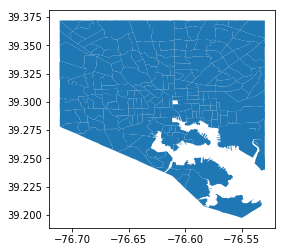

In [ ]:
final.plot()

## Lets make a GIF

Data was successfully merged across all years and geometry.

Now we want the tractname, geometry, and the specific column we want to make a gif from.

In [ ]:
# Get only the results tab
td = final.filter(regex="Births|tract|geometry|centroid")
td = td.reindex(sorted(td.columns), axis=1)

In [ ]:
# Coerce columns stored as floats into integers. 
# This will ensure numbers are rounded to whole digits when displaying the reults

col1 = 'Total Number of Births By Census Tract 2012'
col2 = 'Total Number of Births By Census Tract 2016'
td[[col1, col2]] = td[[col1, col2]].fillna(-1)
td[[col1, col2]] = td[[col1, col2]].astype('int32')
td.head()

,Total Number of Births By Census Tract 2012,Total Number of Births By Census Tract 2013,Total Number of Births By Census Tract 2014,Total Number of Births By Census Tract 2015,Total Number of Births By Census Tract 2016,Total Number of Births By Census Tract 2017,centroid,ctract,geometry
0,49,39,60,38,59,41,POINT (-76.57402...,10100,POLYGON ((-76.57...
1,64,42,49,59,62,44,POINT (-76.57377...,10200,POLYGON ((-76.57...
2,41,40,37,43,32,37,POINT (-76.58018...,10300,POLYGON ((-76.57...
3,37,31,53,33,34,45,POINT (-76.57969...,10400,POLYGON ((-76.57...
4,22,23,28,22,28,28,POINT (-76.58588...,10500,POLYGON ((-76.58...


Data exploration is essential! But not covered in this lab.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb9d9d2470>,
      dtype=object)

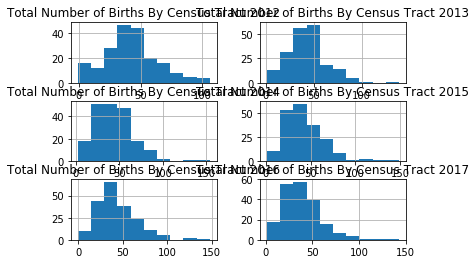

In [ ]:
td.filter(regex="Births").hist()

Everything is almost ready to start making our gifmap!

Lets just get the minimum and maximum values so that our color ramp will have consistent values on each picture.

In [ ]:
# Get Min Max
mins = []
maxs = []
for col in td.columns:
  if col in ['NAME', 'state', 'county', 'ctract', 'geometry', 'centroid'] :
    pass
  else: 
    mins.append(td[col].min())
    maxs.append(td[col].max())
print(mins, maxs)

# set the min and max range for the choropleth map
vmin, vmax = min(mins), max(maxs)
print('Smallest Value: ', vmin, ', Max Value:', vmax)

[-1, 1, 2, 1, -1, 1] [106, 139, 154, 149, 148, 143]
Smallest Value:  -1 , Max Value: 154


In [ ]:
pd.set_option('precision', 0)

merged = td   
fileNames = []
saveGifAs = './Births_By_Tract_With_Count_Label.gif'
labelBounds = True
specialLabelCol = False
annotation = 'Source: Maryland Vital Statistics; Analysis by: Baltimore Neighborhood Indicators Alliance' 
fontsize='22'

# For each column
for indx, col in enumerate(merged.filter(regex="Births").columns):
    if col in ['NAME', 'state', 'county', 'tract', 'geometry'] :
        pass
    else: 
        print('INDEX', indx)
        print('Col: '+str(col) )
        image_name = col+'.jpg'
        fileNames.append(image_name)

        # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
        fig = merged.plot(column=col, cmap='Blues', figsize=(10,10), 
           linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
           legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax) 
        )
        
        # https://stackoverflow.com/questions/38899190/geopandas-label-polygons
        if labelBounds:
          labelColumn = col
          if specialLabelCol: labelColumn = specialLabelCol
          merged.apply(lambda x: fig.annotate(s=x[labelColumn], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
        
        # remove axis of chart and set title
        fig.axis('off')
        fig.set_title(str(col.replace("_", " ")), fontdict={'fontsize': fontsize, 'fontweight' : '3'})
        
        # create an annotation for the  data source
        fig.annotate(annotation,
               xy=(0.1, .08), xycoords='figure fraction',
               horizontalalignment='left', verticalalignment='top',
               fontsize=10, color='#555555')
        
        # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
        # filepath = os.path.join(output_path, image_name)
        chart = fig.get_figure()
        # fig.savefig(“map_export.png”, dpi=300)
        chart.savefig(image_name, dpi=300)
        plt.close(chart)
        
images = []
for filename in fileNames:
    images.append(imageio.imread(filename))
imageio.mimsave(saveGifAs, images, fps=.5)


# This will print out a picture of each picture in the gifmap.
from PIL import Image
import requests
from io import BytesIO
for filename in fileNames:
    img = Image.open(filename) 
    size = 328, 328
    img.thumbnail(size, Image.ANTIALIAS)
    img

# Final Result

In [ ]:
def getMinMax(df):
  # Get Min Max
  mins = []
  maxs = []
  for col in td.columns:
    if col in ['NAME', 'state', 'county', 'ctract', 'geometry', 'centroid'] :
      pass
    else: 
      mins.append(df[col].min())
      maxs.append(df[col].max())
  print(mins, maxs)
  return [mins, maxs]

def getAbsMinMax(df):
  # Get Min Max
  mins, maxs = getMinMax(df)
  return [min(mins), max(maxs)]

def createGif(fileNames, saveGifAs):
  # This will print out a picture of each picture in the gifmap as well.
  images = []
  for filename in fileNames:
      images.append(imageio.imread(filename))
      img = Image.open(filename) 
      size = 328, 328
      img.thumbnail(size, Image.ANTIALIAS)
      print(img)
  imageio.mimsave(saveGifAs, images, fps=.5)

def createPicture(merged, labelBounds, specialLabelCol, annotation, fontsize):
  fileNames = []
  # For each column
  for indx, col in enumerate(merged.filter(regex="Births").columns):
      if col in ['NAME', 'state', 'county', 'tract', 'geometry'] :
          pass
      else: 
          print('INDEX', indx)
          print('Col: '+str(col) )
          image_name = col+'.jpg'
          fileNames.append(image_name)

          # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
          fig = merged.plot(column=col, cmap='Blues', figsize=(10,10), 
             linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
             legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax) 
          )

          # https://stackoverflow.com/questions/38899190/geopandas-label-polygons
          if labelBounds:
            labelColumn = col
            if specialLabelCol: labelColumn = specialLabelCol
            merged.apply(lambda x: fig.annotate(s=x[labelColumn], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

          # remove axis of chart and set title
          fig.axis('off')
          fig.set_title(str(col.replace("_", " ")), fontdict={'fontsize': fontsize, 'fontweight' : '3'})

          # create an annotation for the  data source
          fig.annotate(annotation,
                 xy=(0.1, .08), xycoords='figure fraction',
                 horizontalalignment='left', verticalalignment='top',
                 fontsize=10, color='#555555')

          # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
          # filepath = os.path.join(output_path, image_name)
          chart = fig.get_figure()
          # fig.savefig(“map_export.png”, dpi=300)
          chart.savefig(image_name, dpi=300)
          plt.close(chart)
  return fileNames
  
def createGifMap(df, saveGifAs, labelBounds, specialLabelCol, annotation, fontsize):
  # set the min and max range for the choropleth map
  vmin, vmax = getAbsMinMax(df)
  print('Smallest Value: ', vmin, ', Max Value:', vmax)
  
  fileNames = createPicture(df, labelBounds, specialLabelCol, annotation, fontsize)
  print('Pictures were created')

  createGif(fileNames, saveGifAs)

In [ ]:
pd.set_option('precision', 0)

saveGifAs = './Births_By_Tract_With_Count_Label.gif'
labelBounds = True
specialLabelCol = False
annotation = 'Source: Maryland Vital Statistics; Analysis by: Baltimore Neighborhood Indicators Alliance' 
fontsize='22'

createGifMap(td, saveGifAs, labelBounds, specialLabelCol, annotation, fontsize)

[-1, 1, 2, 1, -1, 1] [106, 139, 154, 149, 148, 143]
Smallest Value:  -1 , Max Value: 154
INDEX 0
Col: Total Number of Births By Census Tract 2012
INDEX 1
Col: Total Number of Births By Census Tract 2013
INDEX 2
Col: Total Number of Births By Census Tract 2014
INDEX 3
Col: Total Number of Births By Census Tract 2015
INDEX 4
Col: Total Number of Births By Census Tract 2016
INDEX 5
Col: Total Number of Births By Census Tract 2017
Pictures were created
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=328x328 at 0x7FEB9C70FEF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=328x328 at 0x7FEB9CB42F98>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=328x328 at 0x7FEB9C70FFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=328x328 at 0x7FEB9CC8B9B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=328x328 at 0x7FEB9C7141D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=328x328 at 0x7FEB9C714470>


In [ ]:
ls

 avocado.csv
 baltimore-births/
 Births_By_Tract_With_Count_Label.gif
 boundaries-baltimore-communities-NoWater-2010.csv
 boundaries-baltimore-communities-NoWater-2010.geojson
 boundaries-baltimore-neighborhoods.csv
 boundaries-baltimore-neighborhoods.geojson
 boundaries-baltimore-neighborhoods.gsheet
 boundaries-baltimore-tracts-NoWater-2010.csv
 boundaries-baltimore-tracts-NoWater-2010.geojson
 boundaries-evanston-tracts-2010.csv
 boundaries-evanston-tracts-2010.geojson
 boundaries-evanston-tracts-2010.gsheet
 boundaries-maryland_census-tracts-2010.csv
 boundaries-maryland_census-tracts-2010.geojson
 boundaries-maryland-counties.csv
 boundaries-maryland-counties.geojson
 boundaries-moco-census-tracts-2010.csv
 boundaries-moco-census-tracts-2010.geojson
 crosswalk-census-communities-2010.gsheet
 dashboardDataColumnDescriptions.csv
 dashboardDataColumnDescriptions.gsheet
 dashboardData.csv
 dashboardData.gsheet
 exemptions/
'Grid view.csv'
 iw.csv
 symbols.json
'Total Number of Births 